In [1]:
import torch
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms #이미지 변환(전처리 기능을 제공하는 라이브러리)
from torch.autograd import Variable

from torch import optim
import torch.nn as nn
import torch.nn.functional as F
import os
import cv2
from PIL import Image
from tqdm import tqdm_notebook as tqdm #진행상황을 가시적으로 표현해주는데, 특히 모델의 학습 경과를 확인하고 시픙ㄹ 때 사용하는 라이브러리
import random
from matplotlib import pyplot as plt
from pprint import pprint
import time
import pandas as pd

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

먼저 모델학습에 필요한 데이터셋의 전처리가 필요하다

## 이미지 데이터셋 전처리

In [3]:
class ImageTransform():
    def __init__(self, resize, mean, std): #__init__은 인스턴스 초기화를 위해 사용하는 메서드
        self.data_transform = {
            'train': transforms.Compose([
                transforms.RandomResizedCrop(resize, scale = (0.5, 1.0)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize(mean, std) #사전훈련된 모델들을 사용하기 위해서는 ImageNet 데이터셋의 각 채널별 평균과 표준편차에 맞는
            ]), #정규화를 해주어야 한다. RGB 채널마다 mean과 std가 있다.
            'val': transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(resize),
                transforms.ToTensor(),
                transforms.Normalize(mean, std)
            ])
        }
        
    def __call__(self, img, phase): #__call__함수는 클래스를 호출할 수 있도록 하는 메서드이다. 인스턴스가 호출되었을 때 실행된다.
        return self.data_transform[phase](img) #클래스 객체 자체를 호출하면, __call__함수의 리턴값이 반환된다.

이미지 데이터 셋을 불러온 후 학습, 검증, 테스트로 분리

In [52]:
cat_directory = r'./data/chap06/data/dogs-vs-cats/Cat/'
dog_directory = r'./data/chap06/data/dogs-vs-cats/Dog/'

cat_images_filepaths = sorted([os.path.join(cat_directory, f) for f in os.listdir(cat_directory)])
dog_images_filepaths = sorted([os.path.join(dog_directory, f) for f in os.listdir(dog_directory)])

images_filepaths = [*cat_images_filepaths, *dog_images_filepaths] #개와 고양이 이미지들을 합쳐서 images_filepaths에 저장
correct_images_filepaths = [i for i in images_filepaths if cv2.imread(i) is not None]

random.seed(42) #동일한 난수 생성. 시드 42로 고정
random.shuffle(correct_images_filepaths)
train_images_filepaths = correct_images_filepaths[:400] #학습용 400개
val_images_filepaths = correct_images_filepaths[400:-10] #검증용 92개의 이미지
test_images_filepaths = correct_images_filepaths[-10:] #테스트용 10개

테스트 데이터셋 이미지 확인 함수

In [5]:
def display_image_grid(images_filepaths, predicted_labels = (), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12,6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        true_label = os.path.normpath(image_filepath).split(os.sep)[-2]
        predicted_label = predicted_labels[i] if predicted_labels else true_label
        color = "green" if true_label == predicted_labels else "red"
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(predicted_label, color = color)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

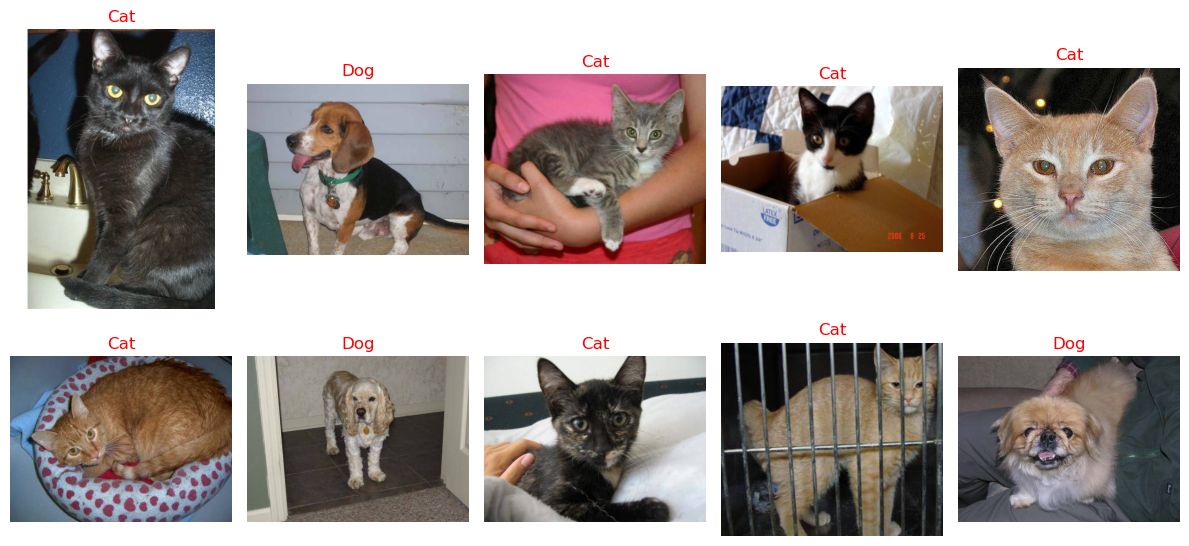

In [6]:
display_image_grid(test_images_filepaths)

In [7]:
pprint(test_images_filepaths)

['./data/chap06/data/dogs-vs-cats/Cat/cat.145.jpg',
 './data/chap06/data/dogs-vs-cats/Dog/dog.211.jpg',
 './data/chap06/data/dogs-vs-cats/Cat/cat.162.jpg',
 './data/chap06/data/dogs-vs-cats/Cat/cat.200.jpg',
 './data/chap06/data/dogs-vs-cats/Cat/cat.210.jpg',
 './data/chap06/data/dogs-vs-cats/Cat/cat.224.jpg',
 './data/chap06/data/dogs-vs-cats/Dog/dog.213.jpg',
 './data/chap06/data/dogs-vs-cats/Cat/cat.109.jpg',
 './data/chap06/data/dogs-vs-cats/Cat/cat.15.jpg',
 './data/chap06/data/dogs-vs-cats/Dog/dog.167.jpg']


데이터셋에는 학습할 데이터의 경로를 정의하고 그 경로에서 데이터를 읽어 온다. 데이터셋 크기가 클 수 있으므로 __init__ 에서 전체 데이터를 읽어오는 것이 아니라 경로만 저장해 높고, __getitem__ 메서드에서 이미지를 읽어온다. 데이터를 어디에서 가져올지 결정한다.

이후, 데이터로더에서 데이터셋의 데이터를 메모리로 불러오는데, 한꺼번에 전체 데이터를 불러오는 것이 아니라 배치 크기만큼 분할하여 가져온다.

## 이미지 데이터셋 클래스 정의

데이터를 불러오는 방법을 정의한다.

In [8]:
class DogvsCatDataset(Dataset):    
    def __init__(self, file_list, transform=None, phase='train'):    
        self.file_list = file_list
        self.transform = transform
        self.phase = phase
        
    def __len__(self):
        return len(self.file_list)
    
    def __getitem__(self, idx):       
        img_path = self.file_list[idx]
        img = Image.open(img_path)        
        img_transformed = self.transform(img, self.phase)
        
        label = img_path.split('/')[-1].split('.')[0]
        if label == 'dog':
            label = 1
        elif label == 'cat':
            label = 0
        return img_transformed, label

전처리에서 사용할 변수에 대한 값들을 정의한다.

In [9]:
size = 224
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
batch_size = 32

훈련과 검증 데이터셋을 준비하면서 전처리도 같이 적용해준다.

In [10]:
train_dataset = DogvsCatDataset(train_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'train')
val_dataset = DogvsCatDataset(val_images_filepaths, transform = ImageTransform(size, mean, std), phase = 'val')
index = 0
print(train_dataset.__getitem__(index)[0].size()) #getitem 함수를 쓰면  transform된 이미지와 라벨이 반환됨
print(train_dataset.__getitem__(index)[1])

torch.Size([3, 224, 224])
0


이전까지 한 것은 전처리 + 데이터셋 정의하기

이제 메모리로 데이터를 불러와서 훈련을 위한 준비를 한다.

## 데이터 로더 정의

Pytorch의 DataLoader는 배치관리를 담당한다. 한 번에 모든 메모리를 불러오지 않고, 데이터를 쪼개서 조금씩 불러온다.

In [11]:
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = True)
dataloader_dict = {'train': train_dataloader, 'val' : val_dataloader}

batch_iterator = iter(train_dataloader)
inputs, label = next(batch_iterator)
print(inputs.size())
print(label)

torch.Size([32, 3, 224, 224])
tensor([0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1,
        0, 0, 0, 0, 1, 0, 1, 1])


## 모델 네트워크 클래스 정의

In [12]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.cnn1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=0) 
        self.relu1 = nn.ReLU() 
        self.maxpool1 = nn.MaxPool2d(kernel_size=2) 
        self.cnn2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=0) 
        self.relu2 = nn.ReLU() # activation
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)         
        self.fc1 = nn.Linear(32*53*53, 512) 
        self.relu5 = nn.ReLU()         
        self.fc2 = nn.Linear(512, 2) 
        self.output = nn.Softmax(dim=1)        
    
    def forward(self, x):
        out = self.cnn1(x) 
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.cnn2(out) 
        out = self.relu2(out) 
        out = self.maxpool2(out) 
        out = out.view(out.size(0), -1) 
        out = self.fc1(out) 
        out = self.fc2(out)                    
        out = self.output(out)
        return out

In [13]:
model = LeNet()
model.to(device)
print(model)

LeNet(
  (cnn1): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (cnn2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=89888, out_features=512, bias=True)
  (relu5): ReLU()
  (fc2): Linear(in_features=512, out_features=2, bias=True)
  (output): Softmax(dim=1)
)


In [14]:
from torchsummary import summary
summary(model, input_size = (3,224,224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 220, 220]           1,216
              ReLU-2         [-1, 16, 220, 220]               0
         MaxPool2d-3         [-1, 16, 110, 110]               0
            Conv2d-4         [-1, 32, 106, 106]          12,832
              ReLU-5         [-1, 32, 106, 106]               0
         MaxPool2d-6           [-1, 32, 53, 53]               0
            Linear-7                  [-1, 512]      46,023,168
            Linear-8                    [-1, 2]           1,026
           Softmax-9                    [-1, 2]               0
Total params: 46,038,242
Trainable params: 46,038,242
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.57
Forward/backward pass size (MB): 19.47
Params size (MB): 175.62
Estimated Total Size (MB): 195.67
--------------------------------

모델 설계가 끝났고, 옵티마이저와 손실함수를 정의한다.

## 옵티마이저와 손심함수 정의

In [15]:
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

## 모델 학습 함수 정의

In [24]:
def train_model(model, dataloader_dict, criterion, optimizer, num_epoch):
    since = time.time()
    best_acc = 0.0
    
    for epoch in range(num_epoch):
        print('Epoch {}/{}'.format(epoch+1, num_epoch))
        print('-'*20)
        
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            epoch_loss = 0.0
            epoch_corrects = 0
            
            for inputs, labels in tqdm(dataloader_dict[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad() #역전파 단계를 실행하기 전, 기울기를 0으로 초기화
                
                with torch.set_grad_enabled(phase=='train'): #역전파 계산을 false나 true조건에 따라 활성/비활성할 수 있다.
                    outputs = model(inputs)
                    #outputs는 cat(0)일 확률과 dog(1)일 확률
                    _, preds = torch.max(outputs, 1) #max함수 안의 두번째 1이라는 것은 연산을 수행할 차원(axis)이다
                    #preds는 0과 1 중 어느 것으로 예측되었는지, 리스트로
                    loss = criterion(outputs, labels) #손실함수를 이용해 오차 계산
                    
                    if phase == 'train':
                        loss.backward() #모델의 학습 가능한 모든 파라미터에 대하여 기울기 계산
                        optimizer.step() #파라미터 갱신하는 step 함수
                    
                    epoch_loss += loss.item() * inputs.size(0) 
                    epoch_corrects += torch.sum(preds == labels.data)
            
            epoch_loss = epoch_loss / len(dataloader_dict[phase].dataset)
            epoch_acc = epoch_corrects.double() / len(dataloader_dict[phase].dataset)
            print('{} Loss : {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
                
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed //60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    return model

In [26]:
num_epoch = 10 #모든 데이터셋을 다 사용하는 것이 1epoch
model = train_model(model, dataloader_dict, criterion, optimizer, num_epoch)

Epoch 1/10
--------------------


C:\Users\Usery\anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:18: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6255 Acc: 0.6775


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6826 Acc: 0.6087
Epoch 2/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6209 Acc: 0.6950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6718 Acc: 0.5761
Epoch 3/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.5990 Acc: 0.7275


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6807 Acc: 0.5870
Epoch 4/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6056 Acc: 0.7050


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6851 Acc: 0.5978
Epoch 5/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6154 Acc: 0.6850


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6885 Acc: 0.5870
Epoch 6/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6138 Acc: 0.6750


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6541 Acc: 0.6196
Epoch 7/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6090 Acc: 0.6675


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6663 Acc: 0.6304
Epoch 8/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6001 Acc: 0.7000


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6840 Acc: 0.6196
Epoch 9/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6267 Acc: 0.6600


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6715 Acc: 0.6304
Epoch 10/10
--------------------


  0%|          | 0/13 [00:00<?, ?it/s]

train Loss : 0.6060 Acc: 0.6950


  0%|          | 0/3 [00:00<?, ?it/s]

val Loss : 0.6622 Acc: 0.5870
Training complete in 0m 23s
Best val Acc: 0.630435


훈련 데이터셋과 더불어 테스트 데이터셋을 모델에 적용하여 정확도를 측정

테스트 용도의 데이터셋을 이용하므로 model.eval()을 사용한다.

In [31]:
id_list = []
pred_list = []
_id = 0
catordog = []

with torch.no_grad(): #역전파 계산을 비활성화
    for test_path in tqdm(test_images_filepaths):
        img = Image.open(test_path)
        _id = test_path.split('/')[-1].split('.')[1]
        transform = ImageTransform(size, mean, std)
        img = transform(img, phase = 'val')
        img = img.unsqueeze(0) #0위치에 차원 추가
        img = img.to(device)
        
        model.eval()
        outputs = model(img)
        preds = F.softmax(outputs, dim=1)[:,1].tolist()
        id_list.append(_id)
        pred_list.append(preds[0])
        if preds[0] > 0.5:
            catordog.append('dog')
        elif preds[0] < 0.5:
            catordog.append('cat')
        else:
            catordog.append('can\'t define')
        
res = pd.DataFrame({
    'id' : id_list,
    'label' : pred_list,
    'classification' : catordog
})

res.sort_values(by = 'id', inplace = True)
res.reset_index(drop=True, inplace = True)

res.to_csv('./test_result_add.csv', index = False)

C:\Users\Usery\anaconda3\envs\dlenv\lib\site-packages\ipykernel_launcher.py:7: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  import sys


  0%|          | 0/10 [00:00<?, ?it/s]

예측 결과를 시각적으로 표현하기 위한 함수를 정의

In [50]:
class_ = classes = {0:'cat', 1:'dog'}
def display_image_grid2(images_filepaths, predicted_labels = (), cols=5):
    rows = len(images_filepaths) // cols
    figure, ax = plt.subplots(nrows = rows, ncols = cols, figsize=(12,6))
    for i, image_filepath in enumerate(images_filepaths):
        image = cv2.imread(image_filepath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        a = random.choice(res['id'].values)
        
        cls = res.loc[res['id'] == a, 'classification'].values[0] #그냥 values로 하면 ['dog']로 title이 나옴.
        
        ax.ravel()[i].imshow(image)
        ax.ravel()[i].set_title(a+cls)
        ax.ravel()[i].set_axis_off()
    plt.tight_layout()
    plt.show()

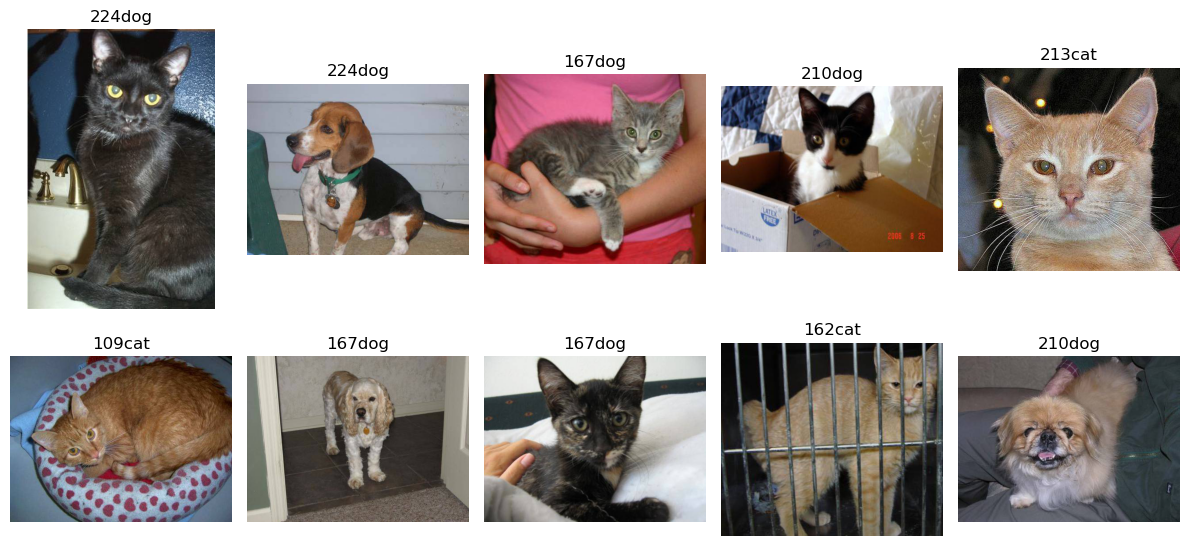

In [51]:
display_image_grid2(test_images_filepaths)